<a href="https://colab.research.google.com/github/RenukaSiriwardhana/Skin-Cancer-Detection--DermaVision/blob/main/notebooks/implementation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/DermaVision/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured...")

Kaggle API configured...


In [3]:
import os

DRIVE_ZIP_PATH = "/content/drive/MyDrive/DermaVision/dataset_cache/ham10000-split-and-augmented.zip"
EXTRACT_PATH = "/content/ham10000_dataset"

os.makedirs("/content/drive/MyDrive/DermaVision/dataset_cache", exist_ok=True)

if not os.path.exists(DRIVE_ZIP_PATH):
    print("Downloading dataset from Kaggle (one time only)...")
    !kaggle datasets download -d ahefatresearch/ham10000-split-and-augmented -p /content --force
    !cp /content/ham10000-split-and-augmented.zip "{DRIVE_ZIP_PATH}"
    print("Dataset zip saved to Drive ")
else:
    print("Dataset already exists in Drive (Skipping download)")

Dataset URL: https://www.kaggle.com/datasets/ahefatresearch/ham10000-split-and-augmented
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 2.84G/2.87G [00:32<00:00, 180MB/s]
100% 2.87G/2.87G [00:33<00:00, 93.1MB/s]
Dataset zip saved to Drive 


In [4]:
!rm -rf "{EXTRACT_PATH}"
!unzip -q "{DRIVE_ZIP_PATH}" -d "{EXTRACT_PATH}"

print("Extracted dataset folders:")
!ls "{EXTRACT_PATH}"

Extracted dataset folders:
test_dir  train_dir  val_dir


In [5]:
import os

BASE_DIR = "/content/ham10000_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train_dir")
TEST_DIR  = os.path.join(BASE_DIR, "test_dir")

print("Train exists:", os.path.exists(TRAIN_DIR))
print("Test exists :", os.path.exists(TEST_DIR))

train_classes = sorted(os.listdir(TRAIN_DIR))
test_classes  = sorted(os.listdir(TEST_DIR))

print("Train classes:", train_classes)
print("Test classes :", test_classes)
print("Number of classes:", len(train_classes))

Train exists: True
Test exists : True
Train classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Test classes : ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes: 7


In [6]:
def count_images_per_class(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".png",".jpeg"))]
            counts[cls] = len(imgs)
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

print("\nTrain counts per class:")
for k, v in train_counts.items():
    print(f"{k}: {v}")

print("\nTest counts per class:")
for k, v in test_counts.items():
    print(f"{k}: {v}")

print("\nTotal train images:", sum(train_counts.values()))
print("Total test images :", sum(test_counts.values()))
print("Total images:", sum(train_counts.values()) + sum(test_counts.values()))


Train counts per class:
akiec: 7854
bcc: 7965
bkl: 7944
df: 7377
mel: 7932
nv: 8004
vasc: 7706

Test counts per class:
akiec: 22
bcc: 27
bkl: 66
df: 6
mel: 35
nv: 663
vasc: 9

Total train images: 54782
Total test images : 828
Total images: 55610


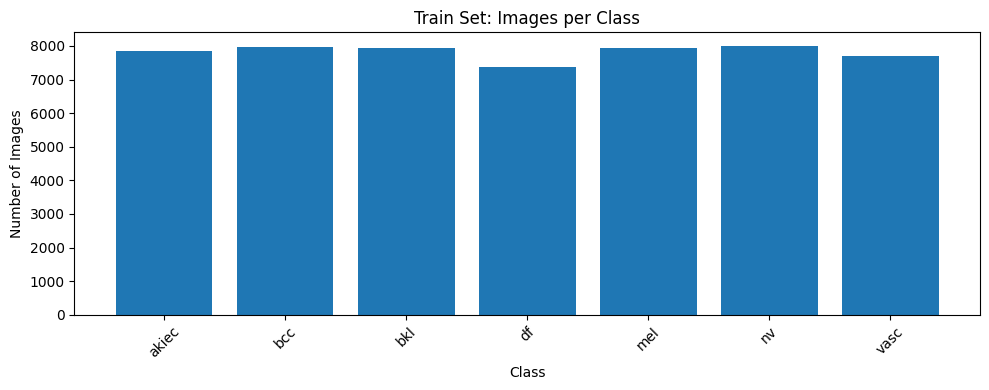

In [7]:
import matplotlib.pyplot as plt

classes = list(train_counts.keys())
values  = list(train_counts.values())

plt.figure(figsize=(10,4))
plt.bar(classes, values)
plt.title("Train Set: Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

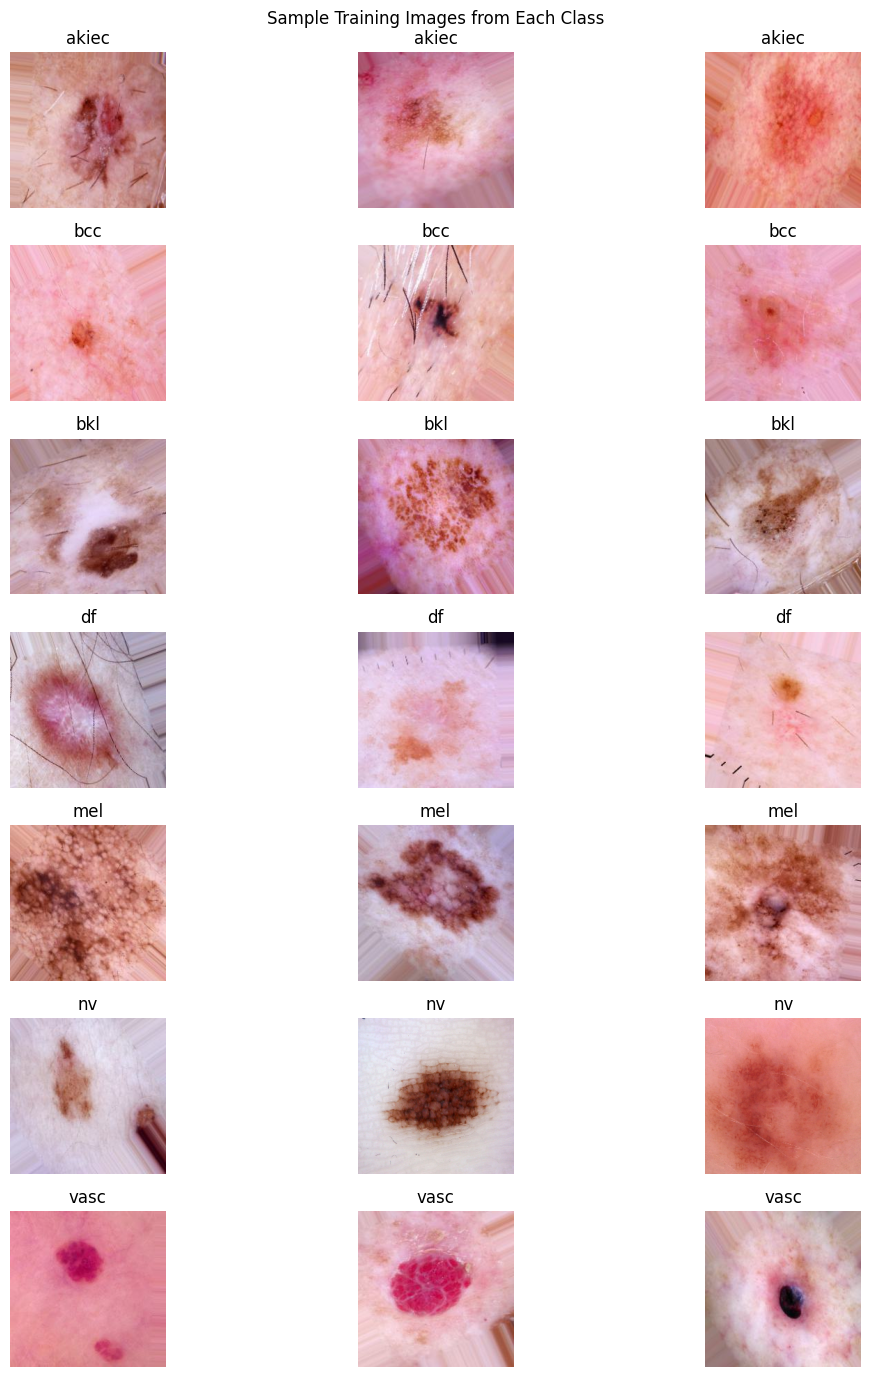

In [8]:
from tensorflow.keras.preprocessing.image import load_img

def show_samples(folder, per_class=3, img_size=(224,224)):
    classes = sorted(os.listdir(folder))
    plt.figure(figsize=(12, 2*len(classes)))
    plot_i = 1

    for cls in classes:
        cls_path = os.path.join(folder, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".png",".jpeg"))][:per_class]

        for img_name in imgs:
            img_path = os.path.join(cls_path, img_name)
            img = load_img(img_path, target_size=img_size)

            plt.subplot(len(classes), per_class, plot_i)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            plot_i += 1

    plt.suptitle("Sample Training Images from Each Class")
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR, per_class=3)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    validation_split=0.2     # 80% train, 20% validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # 7 classes → one-hot encoding
    subset='training',
    shuffle=True
)

Found 43829 images belonging to 7 classes.


In [13]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 10953 images belonging to 7 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # IMPORTANT for confusion matrix later
)

Found 828 images belonging to 7 classes.


In [15]:
print("\n" + "="*50)
print("DATASET INFORMATION AFTER PREPROCESSING")
print("="*50)

print("Training samples   :", train_generator.samples)
print("Validation samples :", validation_generator.samples)
print("Test samples       :", test_generator.samples)

print("\nNumber of classes :", train_generator.num_classes)
print("Class indices     :", train_generator.class_indices)


DATASET INFORMATION AFTER PREPROCESSING
Training samples   : 43829
Validation samples : 10953
Test samples       : 828

Number of classes : 7
Class indices     : {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [16]:
images, labels = next(train_generator)

print("\nBatch Shape Verification")
print("="*50)
print("Image batch shape :", images.shape)
print("Label batch shape :", labels.shape)
print("Image data type   :", images.dtype)
print("Pixel range       :", images.min(), "to", images.max())


Batch Shape Verification
Image batch shape : (32, 224, 224, 3)
Label batch shape : (32, 7)
Image data type   : float32
Pixel range       : 0.0 to 1.0


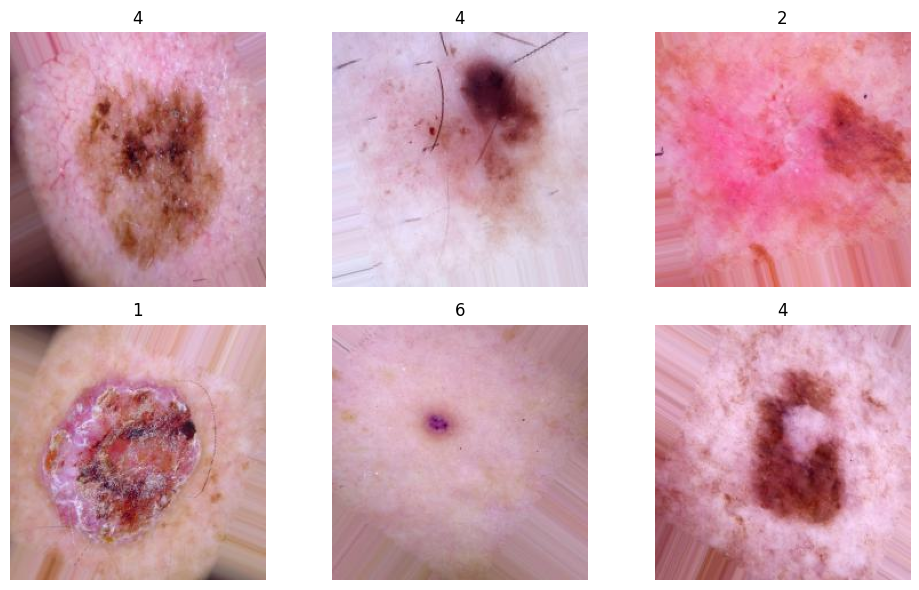

In [17]:
#Visualize one preprocessed batch
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [19]:
model = Sequential([
    layers.Input(shape=(224,224,3)),   # input defined here
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1370/1370 ━━━━━━━━━━━━━━━━━━━━ 165s 114ms/step - accuracy: 0.3660 - loss: 1.6662 - val_accuracy: 0.4951 - val_loss: 1.3058
Epoch 2/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 133s 97ms/step - accuracy: 0.5574 - loss: 1.1299 - val_accuracy: 0.5550 - val_loss: 1.1896
Epoch 3/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.6443 - loss: 0.9095 - val_accuracy: 0.5412 - val_loss: 1.2967
Epoch 4/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - accuracy: 0.7181 - loss: 0.7361 - val_accuracy: 0.5509 - val_loss: 1.3809
Epoch 5/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.7735 - loss: 0.5959 - val_accuracy: 0.5513 - val_loss: 1.7080
Epoch 6/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 125s 91ms/step - accuracy: 0.8346 - loss: 0.4466 - val_accuracy: 0.5634 - val_loss: 1.7416
Epoch 7/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 126s 92ms/step - accuracy: 0.8714 - loss: 0.3481 - val_accuracy: 0.5327 - val_loss: 2.2451
Epoch 8/30
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.9070 - l

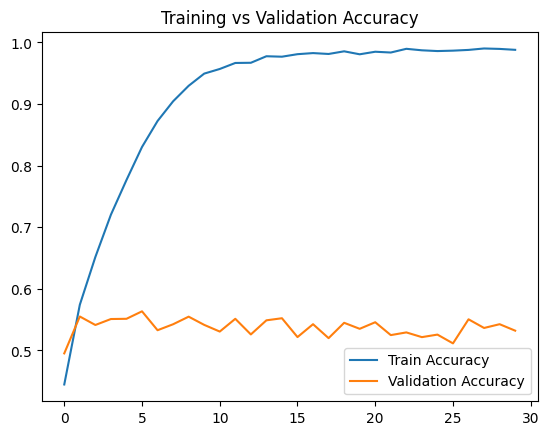

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

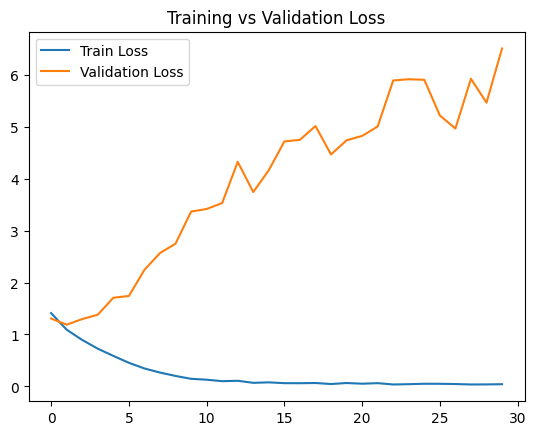

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [25]:
# Evaluate model on unseen test data

y_test_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

test_loss, test_accuracy = model.evaluate(
    test_generator,
    verbose=0
)

print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss    : {test_loss:.4f}")
print("="*50)


FINAL TEST RESULTS
Test Accuracy: 79.47%
Test Loss    : 2.5114


In [26]:
# Make predictions
import numpy as np

y_pred_probabilities = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probabilities, axis=1)

print(f"\nPredictions shape: {y_pred.shape}")
print(f"First 10 predictions: {y_pred[:10]}")


Predictions shape: (828,)
First 10 predictions: [1 2 0 2 3 2 4 0 0 1]


In [27]:
# Classification Report
from sklearn.metrics import classification_report

print("\nClassification Report:")
print("=" * 60)

print(classification_report(
    y_test_labels,
    y_pred,
    target_names=class_names,
    digits=3
))


Classification Report:
              precision    recall  f1-score   support

       akiec      0.294     0.227     0.256        22
         bcc      0.500     0.481     0.491        27
         bkl      0.302     0.288     0.295        66
          df      0.103     0.500     0.171         6
         mel      0.267     0.229     0.246        35
          nv      0.919     0.911     0.915       663
        vasc      1.000     0.667     0.800         9

    accuracy                          0.795       828
   macro avg      0.484     0.472     0.453       828
weighted avg      0.807     0.795     0.799       828



In [28]:
# Create Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels, y_pred)

print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[  5   4   7   3   1   2   0]
 [  2  13   3   3   1   5   0]
 [  6   3  19   4   4  30   0]
 [  0   1   1   3   0   1   0]
 [  1   1   9   2   8  14   0]
 [  3   3  23  14  16 604   0]
 [  0   1   1   0   0   1   6]]


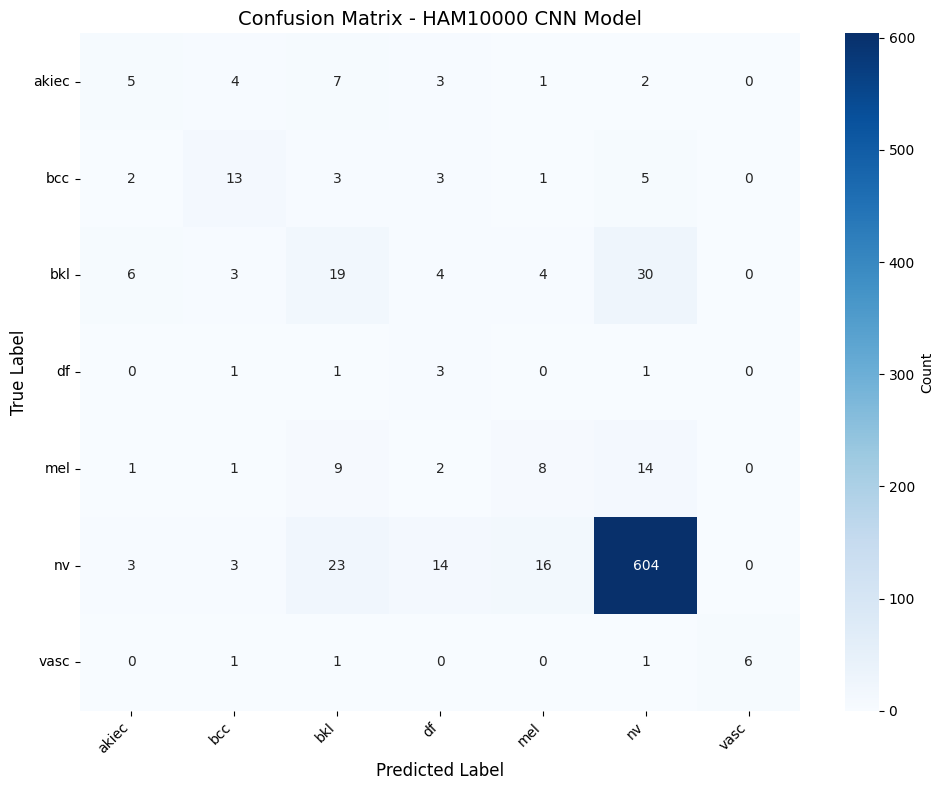

In [29]:
# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"}
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - HAM10000 CNN Model", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
# Most Common Misclassifications
print("\nMost Common Misclassifications:")
print("=" * 60)

num_classes = len(class_names)

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 20:
            print(f"{class_names[i]} misclassified as {class_names[j]} : {cm[i, j]} times")


Most Common Misclassifications:
bkl misclassified as nv : 30 times
nv misclassified as bkl : 23 times


In [31]:
# Save Model
import os

os.makedirs("models", exist_ok=True)

model_path = "models/model_v1.h5"
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: models/model_v1.h5


In [32]:
# Verify Saved Model

if os.path.exists(model_path):
    print("Model file exists in models/ directory")
else:
    print("Model file NOT found")

Model file exists in models/ directory
